In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import root_scalar

from gpcg import GPCGSolver
from gpcg import make_1d_signal, make_shepp_logan_image, build_1d_first_order_grad, build_2d_first_order_grad

# Test problem

In [7]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Make test signal
dom = np.linspace(0, 1, 100)
x = make_1d_signal( dom ) + np.sin(5*dom)

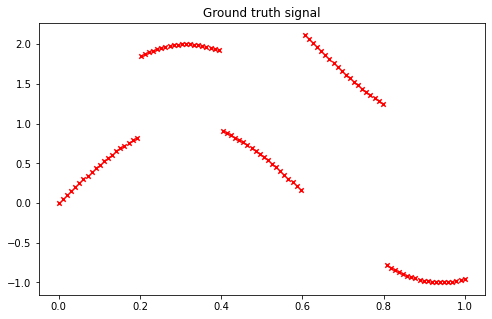

In [8]:
plt.figure(figsize=(8,5))
plt.scatter(dom, x, marker="x", color="red", s=20.0)
plt.title("Ground truth signal")
plt.show()

In [14]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [15]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

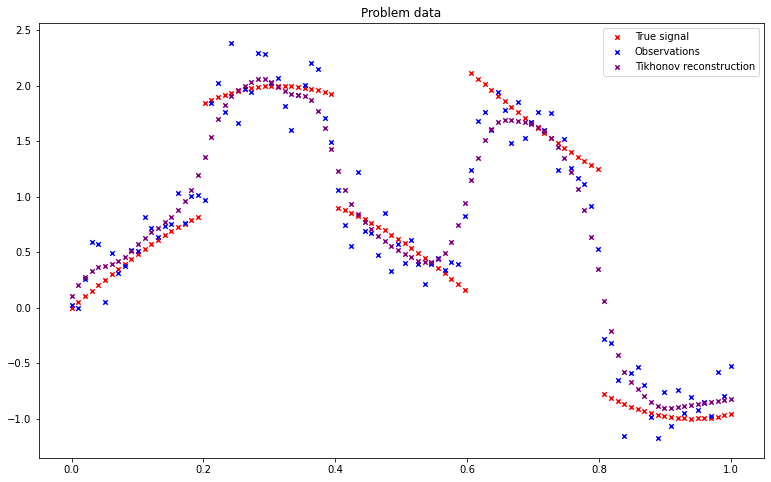

In [16]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

# Set up discrepancy principle method

In [18]:
from scipy.optimize import root_scalar
from regtoolkit.cg import relative_residual_cg

In [56]:
def discrepancy_principle(F, R, y, noise_sigma, safeguard_fac=1.05, cg_tol=1e-4, cg_maxits=1000, lambda_0=1e-4, lambda_1=1e4):
    """Computes a regularization parameter estimate using the discrepancy principle.

    Uses bisection method for finding root of

        f(\lambda) = (1/m)\| F x_{\lambda} - y \|_2^2 - \sigma^2,

    where a unique root is assumed to lie in the interval [lambda_0, lambda_1].

    noise_sigma is an estimate of the standard deviation of i.i.d. Gaussian noise in the signal.
    """
    # Get # measurements
    m = len(y)

    # Setup
    x_lambda = None

    # Define objective
    def _objective(lam):
        x_lambda = None

        # Get current solution
        Q = (F.T @ F) + lam*(R.T @ R)
        sol = relative_residual_cg(Q, F.T @ y, eps=cg_tol, maxits=cg_maxits, x0=x_lambda)
        x_lambda = sol["x"]

        # Evaluate objective
        objective = (1/m)*( (np.linalg.norm( (F @ x_lambda) - y, ord=2)**2) ) - safeguard_fac*(noise_sigma**2)

        return objective
    
    # Call solver
    bisection_sol = root_scalar(_objective, method="bisect", bracket=[lambda_0, lambda_1])

    # Also return the solution for this given lambda
    Q = (F.T @ F) + bisection_sol.root*(R.T @ R)
    sol = relative_residual_cg(Q, F.T @ y, eps=cg_tol, maxits=cg_maxits, x0=x_lambda)
    x_lambda = sol["x"]

    # Form output
    data = {
        "scipy_solve": sol,
        "lambda": bisection_sol.root,
        "x_lambda": x_lambda,
    }

    return data

In [59]:
data = discrepancy_principle(F, R, y, noise_sigma, cg_maxits=1000)

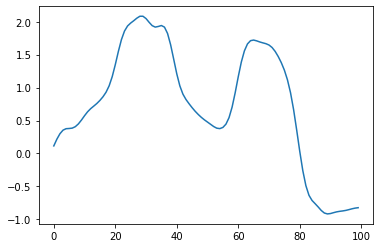

In [60]:
plt.plot(data["x_lambda"])
plt.show()

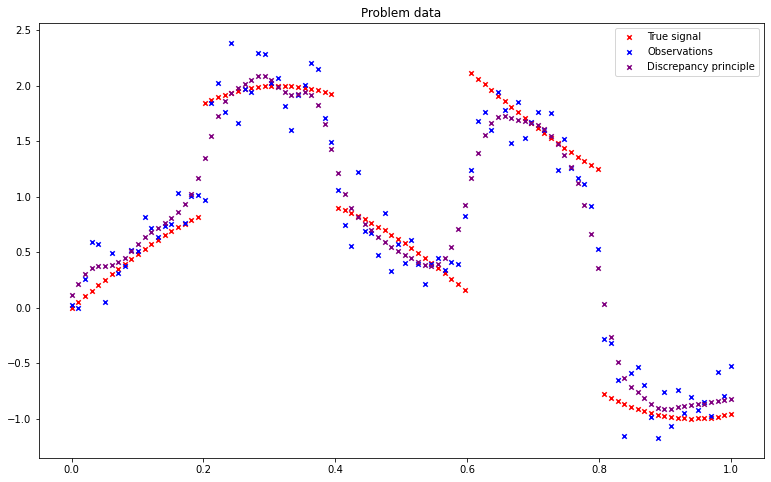

In [62]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
#plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.scatter(dom, data["x_lambda"], marker="x", color="purple", s=20.0, label="Discrepancy principle")
plt.legend()
plt.title("Problem data")
plt.show()